# Homework 5

The goal of this assignment is to determine whether a reviewer will recommend a product or not based on review title and review.

### Importing libraries and the dataset

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import Normalizer

In [220]:
train_whole = pd.read_csv("hw5_data_train.csv")
test_whole = pd.read_csv("hw5_data_test.csv")

train_whole = train_whole.dropna()
test_whole = test_whole.dropna()

X_train = train_whole.iloc[:,[0,1]]
y_train = train_whole["Recommended"]
X_test = test_whole.iloc[:,[0,1]]
y_test = test_whole["Recommended"]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

I decided to drop the rows that had NaN's because it didn't significantly decrease the dataset, and it didn't make sense at least for the first task to try to predict recommendations one blank titles/reviews.

### Task 1
In this task we use CountVectorizer and train a linear classifier (Logistic Regression) on different subsets of the data, visualize the 20 most important features, and then tune the regularization parameter and visualize the 20 most important features after regularization. I have decided to evaluate each model's performance using the average precision metric.

#### Part 1: Using title only

In [199]:
import warnings
warnings.filterwarnings('ignore')

titles_train = X_train['Title']
titles_val = X_val['Title']

vect = CountVectorizer()
X_train_titles = vect.fit_transform(titles_train)
X_val_titles = vect.transform(titles_val)
title_feature_names = vect.get_feature_names()
lr_title = LogisticRegressionCV().fit(X_train_titles, y_train)

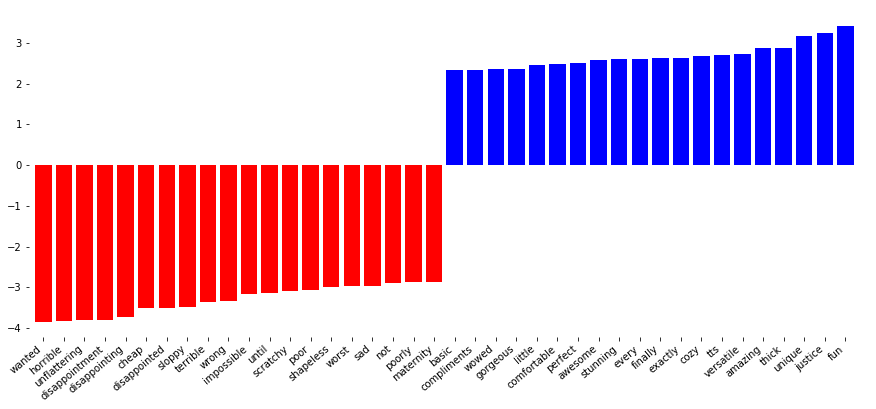

In [200]:
## Note: the following code has been borrowed from Prof. Mueller's class code
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)
    
plt.figure(figsize=(15, 6))
plot_important_features(lr_title.coef_.ravel(), np.array(title_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

Initially, the best/worst features seem to make sense, except for "wanted" in the negative side (probably because it was paired with "not" right in front of it. Now to tune regularization parameter C:

In [149]:
param_grid = {"C": [100, 10, 1, 0.1, 0.001]}
grid_titles = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_titles.fit(X_train_titles, y_train)
print(grid_titles.best_params_)

{'C': 10}


Average precision of logistic regression using titles: 0.915


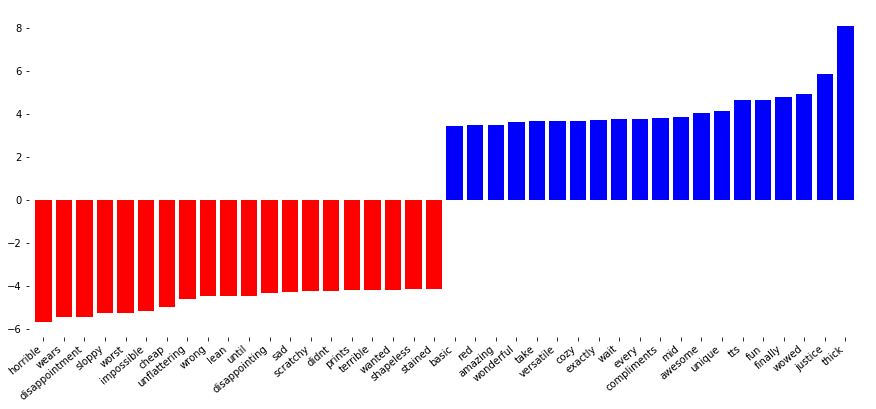

In [203]:
lr_title_tuned = LogisticRegression(C=10).fit(X_train_titles, y_train)

lr_title_tuned_scores = lr_title_tuned.predict(X_val_titles)

ap_title = average_precision_score(y_val, lr_title_tuned_scores)
print("Average precision of logistic regression using titles: {:.3f}".format(ap_title))

plt.figure(figsize=(15, 6))
plot_important_features(lr_title_tuned.coef_.ravel(), np.array(title_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

After regularization, the best/worst features make a lot more sense, except for "thick" being so positively correlated (although perhaps it's good that the clothing is thick?). The average precision score on just titles is 0.915, which is a solid starting point.

#### Part 1.2: Using the review body only

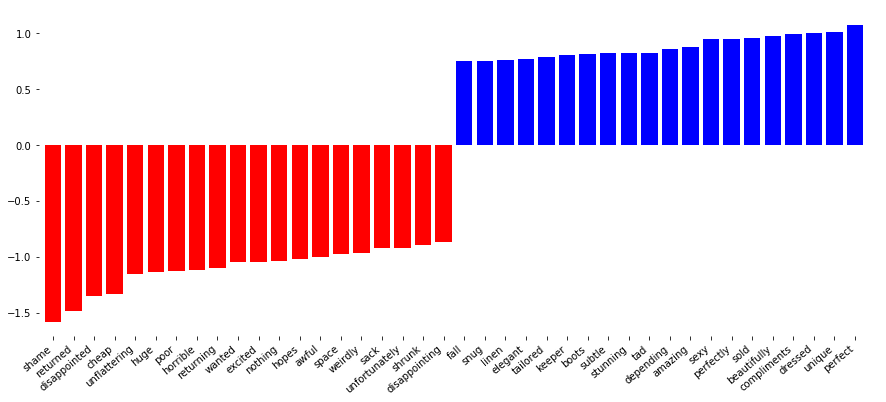

In [152]:
reviews_train = X_train['Review']
reviews_val = X_val['Review']

vect1 = CountVectorizer()
X_train_reviews = vect1.fit_transform(reviews_train)
X_val_reviews = vect1.transform(reviews_val)
review_feature_names = vect1.get_feature_names()
lr_review = LogisticRegressionCV().fit(X_train_reviews, y_train)


plt.figure(figsize=(15, 6))
plot_important_features(lr_review.coef_.ravel(), np.array(review_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

When we switch to looking at reviews, it makes sense that the feature coefficients decrease in magnitude (with so many more words, it makes sense that the value of each individual word in a review decreases).

In [153]:
param_grid = {"C": [100, 10, 1, 0.1, 0.001]}
grid_reviews = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_reviews.fit(X_train_reviews, y_train)
print(grid_reviews.best_params_)

{'C': 0.1}


Average precision of logistic regression using reviews: 0.906


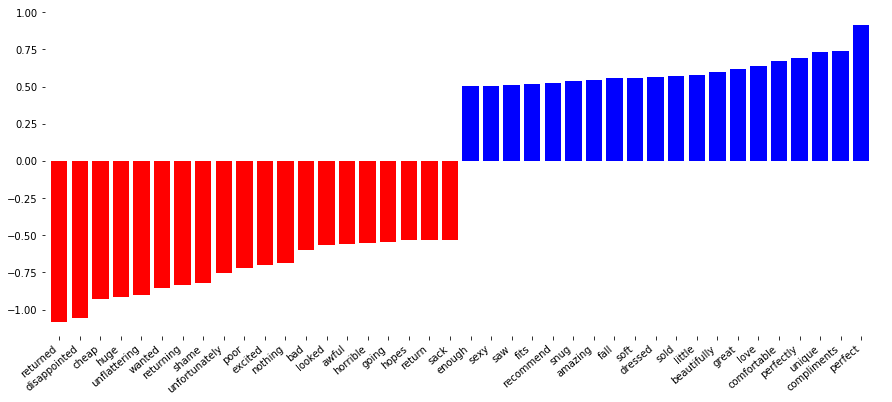

In [204]:
lr_review_tuned = LogisticRegression(C=0.1).fit(X_train_reviews, y_train)

lr_review_tuned_scores = lr_review_tuned.predict(X_val_reviews)

ap_review = average_precision_score(y_val, lr_review_tuned_scores)
print("Average precision of logistic regression using reviews: {:.3f}".format(ap_review))

plt.figure(figsize=(15, 6))
plot_important_features(lr_review_tuned.coef_.ravel(), np.array(review_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

The review corpus performs slightly worse than the titles, perhaps because each feature seems to have a lower coefficient.

#### Part 1.3: Concatenate the title and review to a single text

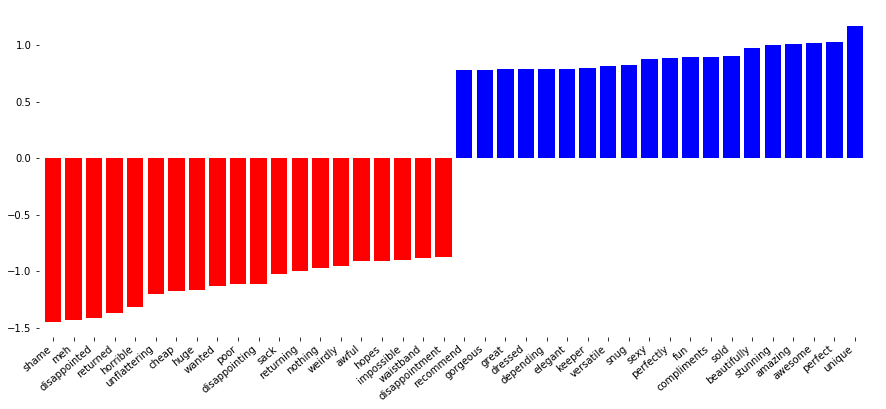

In [158]:
combined_train = X_train['Title'].astype(str)+' '+X_train['Review']
combined_val = X_val['Title'].astype(str)+' '+X_val['Review']

vect2 = CountVectorizer()
X_train_combined = vect2.fit_transform(combined_train)
X_val_combined = vect2.transform(combined_val)
combined_feature_names = vect2.get_feature_names()
lr_combined = LogisticRegressionCV().fit(X_train_combined, y_train)

plt.figure(figsize=(15, 6))
plot_important_features(lr_combined.coef_.ravel(), np.array(combined_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

The feature coefficients are greater for the combined dataset than the titles/reviews alone. We're starting to see trends in the same words appearing, such as "perfect", "unique", on the good side and "disappointed" and "return-" on the bad side.

In [159]:
param_grid = {"C": [100, 10, 1, 0.1, 0.001]}
grid_combined = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_combined.fit(X_train_combined, y_train)
print(grid_combined.best_params_)

{'C': 0.1}


Average precision of logistic regression using both: 0.921


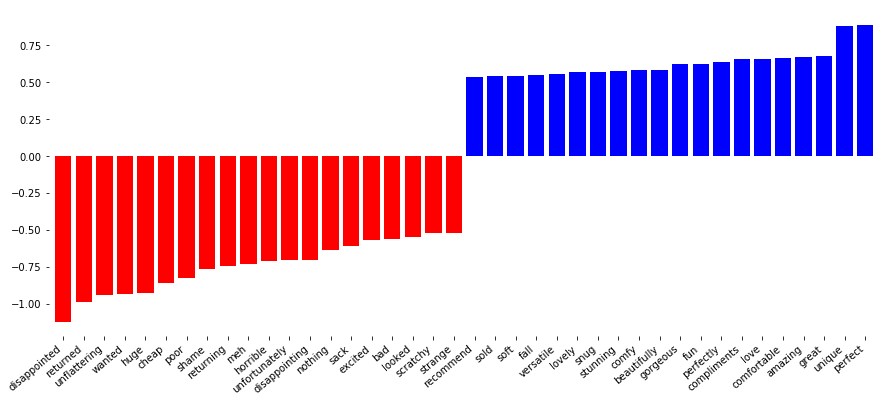

In [205]:
lr_combined_tuned = LogisticRegression(C=0.1).fit(X_train_combined, y_train)

lr_combined_tuned_scores = lr_combined_tuned.predict(X_val_combined)

ap_combined = average_precision_score(y_val, lr_combined_tuned_scores)
print("Average precision of logistic regression using both: {:.3f}".format(ap_combined))

plt.figure(figsize=(15, 6))
plot_important_features(lr_combined_tuned.coef_.ravel(), np.array(combined_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

The combined set has a better average precision as well, 0.921.

#### Part 1.4: Vectorizing title and review individually and concatenating the vector representations

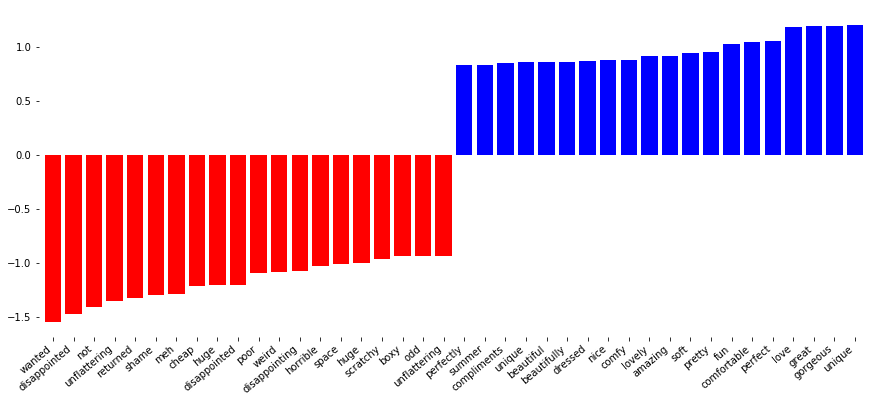

In [170]:
X_train_ind = hstack((X_train_titles, X_train_reviews))
X_val_ind = hstack((X_val_titles, X_val_reviews))
ind_feature_names = title_feature_names + review_feature_names

lr_combined = LogisticRegressionCV().fit(X_train_ind, y_train)

plt.figure(figsize=(15, 6))
plot_important_features(lr_combined.coef_.ravel(), np.array(ind_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [171]:
param_grid = {"C": [100, 10, 1, 0.1, 0.001]}
grid_ind = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_ind.fit(X_train_ind, y_train)
print(grid_ind.best_params_)

{'C': 0.1}


There is a bit more variation in the top important features, such as "love", "great", and "gorgeous" surpassing "perfect" on the good side and "wanted" returning to the top negative feature. For all 4 sub-parts of this task, the feature coefficients have hovered at or a little higher than 1.

Average precision of logistic regression using both (combined separately): 0.920


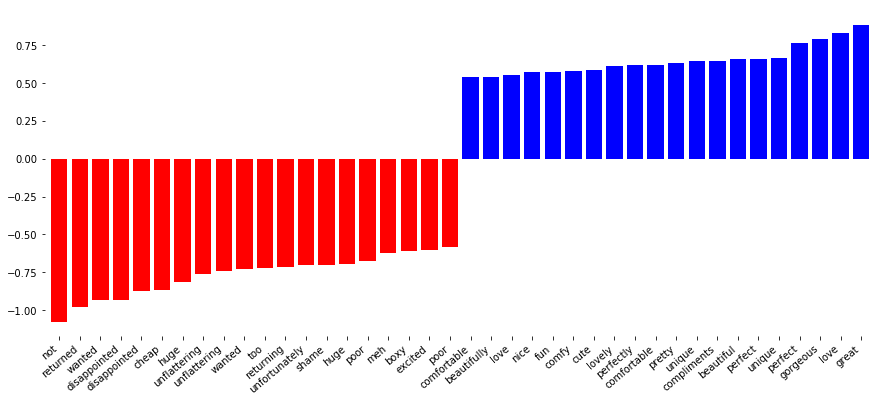

In [206]:
lr_ind_tuned = LogisticRegression(C=0.1).fit(X_train_ind, y_train)

lr_ind_tuned_scores = lr_ind_tuned.predict(X_val_ind)

ap_ind = average_precision_score(y_val, lr_ind_tuned_scores)
print("Average precision of logistic regression using both (combined separately): {:.3f}".format(ap_ind))

plt.figure(figsize=(15, 6))
plot_important_features(lr_ind_tuned.coef_.ravel(), np.array(ind_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

The dataset that is combined after vectorization performs only slightly worse than the dataset combined vefore vectorization (0.920 vs 0.921). Because the pre-vectorization combination dataset out-performs the post-vectorization combination dataset with regards to average precision (and seems to have similar feature coefficients), it seems like the model created in part 3 is the best model in this task. See the evaluation on the test set using average precision below.

In [221]:
combined_test = X_test['Title'].astype(str)+' '+X_test['Review']
X_test = vect2.transform(combined_test)

lr_combined_test_scores = lr_combined_tuned.predict(X_test)

ap_combined_test = average_precision_score(y_test, lr_combined_test_scores)
print("Average precision of logistic regression using test set: {:.3f}".format(ap_combined_test))

Average precision of logistic regression using test set: 0.920


0.920 is a good average precision score for the test set, which thus somewhat validates the model choice.

### Task 2
#### Part 2.1: Try using TfidfVectorizer instead of CountVectorizer (on model 3)

In [270]:
tfidf_pipe = make_pipeline(TfidfVectorizer(),LogisticRegressionCV(Cs = (100, 10, 1, 0.1, 0.001),
                                                                  cv=10),memory="cache_folder")
tfidf_pipe.fit(combined_train, y_train)
lr_tfidf = tfidf_pipe.named_steps['logisticregressioncv']
tfidf_feature_names = np.array(tfidf_pipe.named_steps['tfidfvectorizer'].get_feature_names())
print(lr_tfidf.C_)

[10.]


Average precision of logistic regression using both with TfidfVectorizer: 0.923


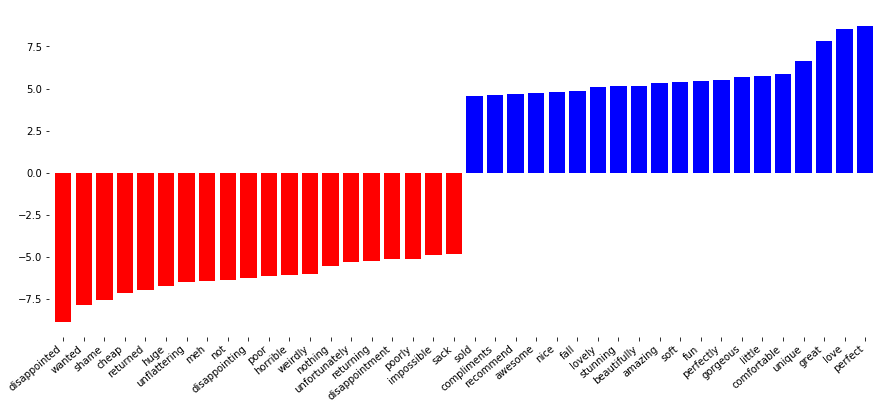

In [271]:
lr_tfidf_tuned = LogisticRegression(C=10).fit(X_train_com_tfidf, y_train)

lr_tfidf_tuned_scores = lr_tfidf_tuned.predict(X_val_com_tfidf)

ap_tfidf = average_precision_score(y_val, lr_tfidf_tuned_scores)
print("Average precision of logistic regression using both with TfidfVectorizer: {:.3f}".format(ap_tfidf))

plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_tuned.coef_.ravel(), np.array(tfidf_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

The first and most obvious change that can be seen using TfidfVectorizer is a large increase in magnitude in feature coefficients. It didn't seem to change which features are important, but the scale of measurement seems to have shifted out of the 0 +/- 1 range to the 0 +/- 7.5 range. The average precision score also increased to 0.0923, which is a small but noteworthy improvement.

#### Part 2.2: Using a Normalizer with CountVectorizer to see if it changes the outcome.

In [268]:
norm_pipe = make_pipeline(CountVectorizer(), Normalizer(),
                          LogisticRegressionCV(Cs = (100, 10, 1, 0.1, 0.001), cv=10),memory="cache_folder")
norm_pipe.fit(combined_train, y_train)
lr_norm = norm_pipe.named_steps['logisticregressioncv']
norm_feature_names = np.array(norm_pipe.named_steps['countvectorizer'].get_feature_names())
print(lr_norm.C_)

[10.]


Average precision of logistic regression using Normalizer: 0.922


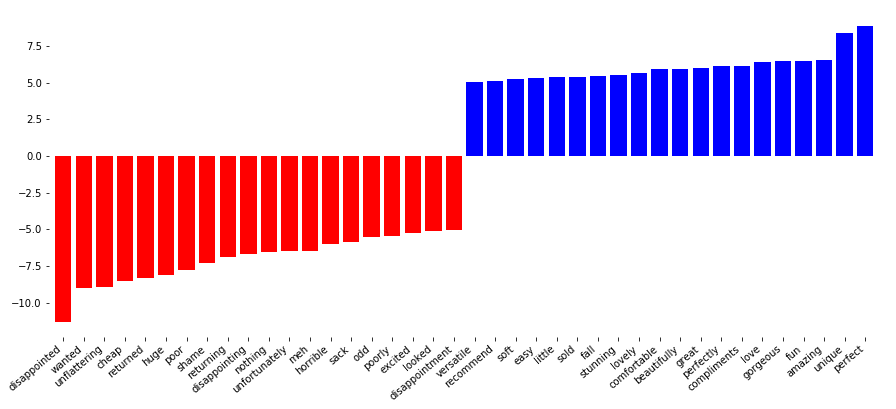

In [269]:
lr_norm_tuned = LogisticRegression(C=10).fit(X_train_norm, y_train)

lr_norm_tuned_scores = lr_norm_tuned.predict(X_val_norm)

ap_norm = average_precision_score(y_val, lr_norm_tuned_scores)
print("Average precision of logistic regression using Normalizer: {:.3f}".format(ap_norm))

norm_feature_names = vects.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_norm_tuned.coef_.ravel(), np.array(norm_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

Using the Normalizer does present a seemingly larger shift/shuffle in the important features. On the good side, "amazing" and "fun" are now among the more important features and "unique" and "perfect" are now visibly more important than the other important features. On the bad side, the words present seems pretty similar to before ("disappointed" and "wanted" are still among the top features), but "disappointed" is now seemingly much more important than the other features. The scale of feature coefficients also appears to have increased to 0 +/- 10. The average precision (0.922) is nearly as good as that of TfidfVectorizer.

#### Part 2.3: Using stop-word

In [201]:
vect4 = CountVectorizer(stop_words='english')
X_train_stop = vect4.fit_transform(combined_train)
X_val_stop = vect4.transform(combined_val)
stop_feature_names = vect4.get_feature_names()

param_grid = {"C": [100, 10, 1, 0.1, 0.001]}
grid_stop = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_stop.fit(X_train_stop, y_train)
print(grid_stop.best_params_)

{'C': 0.1}


Average precision of logistic regression using English stop-words: 0.915


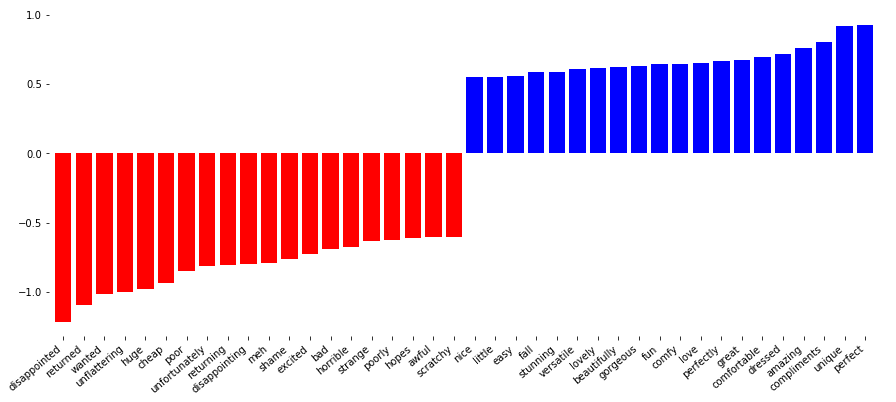

In [213]:
lr_stop_tuned = LogisticRegression(C=0.1).fit(X_train_stop, y_train)

lr_stop_tuned_scores = lr_stop_tuned.predict(X_val_stop)

ap_stop = average_precision_score(y_val, lr_stop_tuned_scores)
print("Average precision of logistic regression using English stop-words: {:.3f}".format(ap_stop))

plt.figure(figsize=(15, 6))
plot_important_features(lr_stop_tuned.coef_.ravel(), np.array(stop_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

It doesn't seem that the English stop-words help, as evidenced by the decrease in average precision. Additionally, it's noteworthy that the feature importances have returned to 0 +/- 1. There doesn't seem to be a substantial improvement from using the stop-words, which makes sense since stop-words aren't as useful for doing supervised learning on large datasets (which is what we're trying to do here).

#### Part 2.4:  Limit the vocabulary using min_df or max_df

In [227]:
vect5 = CountVectorizer(min_df = 4)
X_train_df = vect5.fit_transform(combined_train)
X_val_df = vect5.transform(combined_val)
df_feature_names = vect5.get_feature_names()

param_grid = {"C": [100, 10, 1, 0.1, 0.001]}
grid_df = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_df.fit(X_train_df, y_train)
print(grid_df.best_params_)

{'C': 0.1}


Average precision of logistic regression using min_df = 4: 0.921


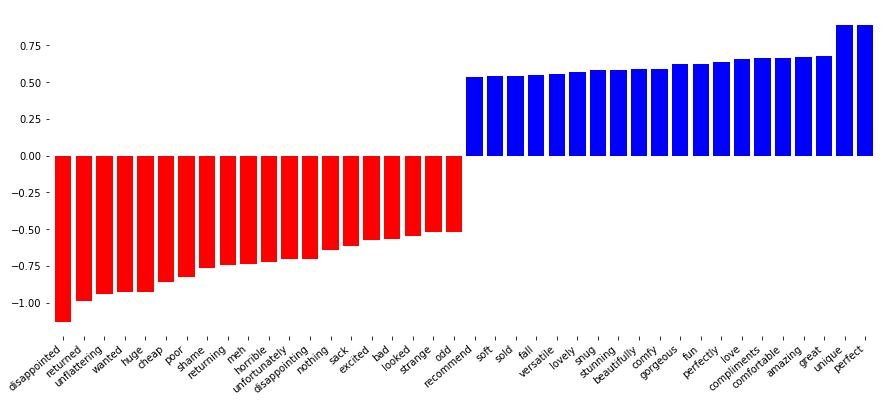

In [229]:
lr_df_tuned = LogisticRegression(C=0.1).fit(X_train_df, y_train)

lr_df_tuned_scores = lr_df_tuned.predict(X_val_df)

ap_df = average_precision_score(y_val, lr_df_tuned_scores)
print("Average precision of logistic regression using min_df = 4: {:.3f}".format(ap_df))

plt.figure(figsize=(15, 6))
plot_important_features(lr_df_tuned.coef_.ravel(), np.array(df_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [230]:
print(X_train_combined.shape)
print(X_train_df.shape)

(11071, 11094)
(11071, 4195)


Setting min_df to 4 seems visually show similar results to using the normalizer in the sense that "disappointed", "unique", and "perfect" seem to have sharply higher coefficients than the other important features. Other than that, there doesn't seem to be a large difference in average precision (note again the feature coefficients are 0 +/- 1). Above you can see the reduction in features that occurs when you set min_df=4. This likely also allowed for the model to run a bit faster. 

Although the first and second models of this task perform similarly, I decided to choose CountVectorizer + Normalizer because while it is 0.001 less precise because the features chosen by this model were a bit more intuitive and unique (meaning there weren't a lot of features expressing the same meaning as each other).

In [235]:
X_test_count = vects.transform(combined_test)
X_test_norm = norm.transform(X_test_count)

lr_norm_test_scores = lr_norm_tuned.predict(X_test_norm)

ap_norm_test = average_precision_score(y_test, lr_norm_test_scores)
print("Average precision of logistic regression using test set: {:.3f}".format(ap_norm_test))


Average precision of logistic regression using test set: 0.925


The chosen model improved upon Task 1's chosen model, with an average precision of 0.925.

### Task 3
#### Part 3.1 Switching from unigrams to n-grams

Average precision of logistic regression for bigrams: 0.915


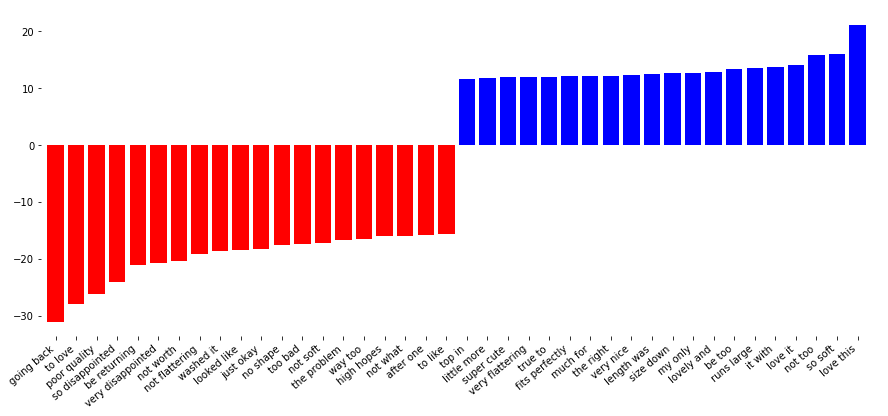

In [308]:
bigram_pipe = make_pipeline(CountVectorizer(ngram_range=(2,2)), Normalizer(),
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
bigram_pipe.fit(combined_train, y_train)

lr_bigram = bigram_pipe.named_steps['logisticregressioncv']
bigram_feature_names = np.array(bigram_pipe.named_steps['countvectorizer'].get_feature_names())
bigram_scores = bigram_pipe.predict(combined_val)

ap_bigram = average_precision_score(y_val, bigram_scores)
print("Average precision of logistic regression for bigrams: {:.3f}".format(ap_bigram))

plt.figure(figsize=(15, 6))
plot_important_features(lr_bigram.coef_.ravel(), np.array(bigram_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

I first decided to look at bigrams to see how they performed. It seems they performed slightly worse than unigrams, with an average precision score of 0.915 (compared to 0.920). It is interesting to see which phrases are seen as most important, and particularly odd that "to love" has such a negative coefficient. Perhaps the full phrase was "hard to love"? Regardless, next I will try tri-grams.

Average precision of logistic regression: 0.893


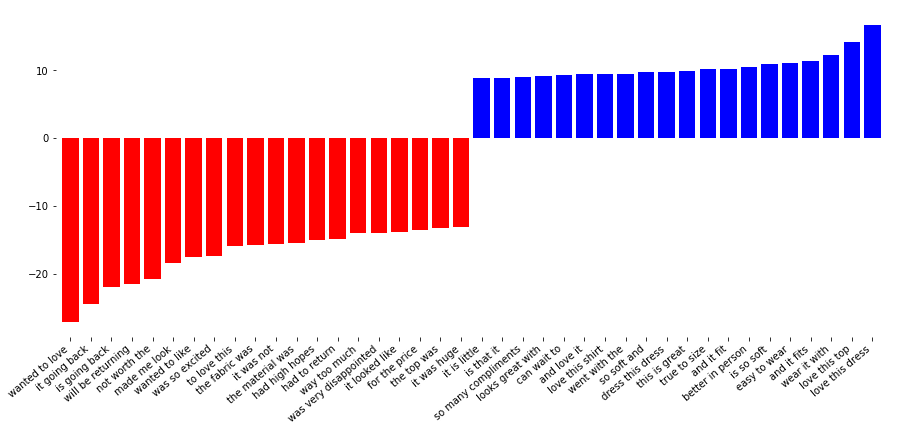

In [309]:
trigram_pipe = make_pipeline(CountVectorizer(ngram_range=(3,3)), Normalizer(),
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
trigram_pipe.fit(combined_train, y_train)

lr_trigram = trigram_pipe.named_steps['logisticregressioncv']
trigram_feature_names = np.array(trigram_pipe.named_steps['countvectorizer'].get_feature_names())
trigram_scores = trigram_pipe.predict(combined_val)

ap_trigram = average_precision_score(y_val, trigram_scores)
print("Average precision of logistic regression: {:.3f}".format(ap_trigram))

plt.figure(figsize=(15, 6))
plot_important_features(lr_trigram.coef_.ravel(), np.array(trigram_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

The trigram performed worse than the bigram, with the average precision score dropping to 0.893. We do get an answer to our question from before - the phrase that had such a negative coefficient wasn't "hard to love" as I had thought, but "wanted to love". Interestingly, with both the bi- and tri-grams, the feature coefficients are in the 20-30 range, whereas they had been 10 at most with unigrams. The graph of feature coefficients are more helpful as n increases, because we get more insight into what exact phrases have such a strong positive/negative correlation.

Average precision of logistic regression: 0.917


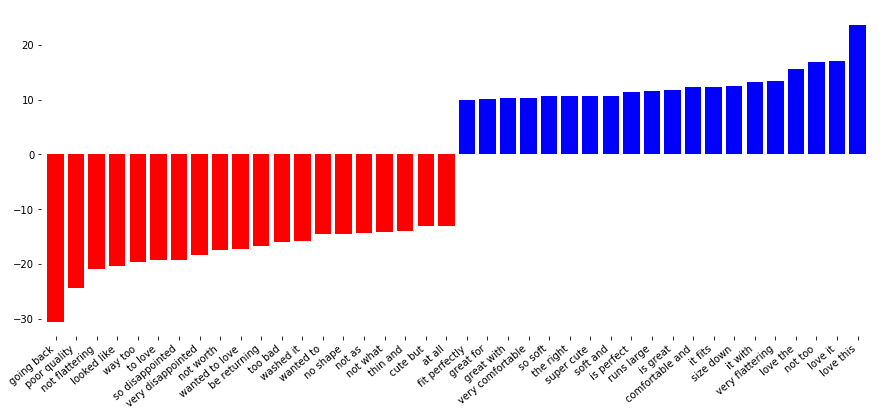

In [310]:
ngram_pipe = make_pipeline(CountVectorizer(ngram_range=(2,4)), Normalizer(), 
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
ngram_pipe.fit(combined_train, y_train)

lr_ngram = ngram_pipe.named_steps['logisticregressioncv']
ngram_feature_names = np.array(ngram_pipe.named_steps['countvectorizer'].get_feature_names())
ngram_scores = ngram_pipe.predict(combined_val)

ap_ngram = average_precision_score(y_val, ngram_scores)
print("Average precision of logistic regression: {:.3f}".format(ap_ngram))

plt.figure(figsize=(15, 6))
plot_important_features(lr_ngram.coef_.ravel(), np.array(ngram_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

Although neither the bi- or trigram outperformed the unigram, I wanted to get a better impression of the higher n-grams if we aren't so singularly restrictive on n (i.e. we let it be a range rather than a fixed value). The graph above visualizes the higher-order n-grams, from which we can see that by far, the best positive feature is "love this/it" and the best negative feature is "going back". As I said above, while the bi-/trigrams are not as precise as the unigrams, I think they're much more helpful as a tool to visualize/aid understanding of why certain words are seen as important features in the unigram.

#### Part 3.2: Using character ngrams

Average precision of logistic regression: 0.902


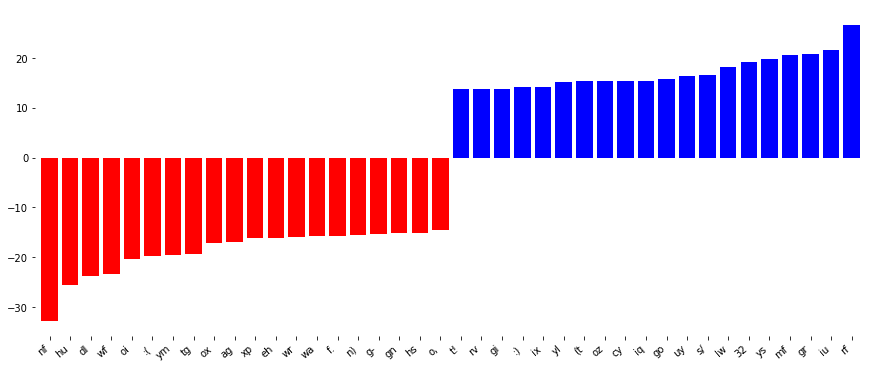

In [311]:
char_pipe = make_pipeline(CountVectorizer(ngram_range=(2,2),analyzer='char'), Normalizer(),
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
char_pipe.fit(combined_train, y_train)

lr_char = char_pipe.named_steps['logisticregressioncv']
char_feature_names = np.array(char_pipe.named_steps['countvectorizer'].get_feature_names())
char_scores = char_pipe.predict(combined_val)

ap_char = average_precision_score(y_val, char_scores)
print("Average precision of logistic regression: {:.3f}".format(ap_char))

plt.figure(figsize=(15, 6))
plot_important_features(lr_char.coef_.ravel(), np.array(char_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

There are a couple interesting things to observe about switching from word to character ngrams. First, that they are on the whole, not as helpful as word ngrams (see the drop in average precision score). Second, they are somewhat hard to interpret, because other than "eh", I don't really know what any of these character combinations mean. But last, and I think most importantly, I find it amusing that a smiley face ( :) ) has made it into the top positive features and a frowny face ( :( ) has made it into the top negative features. It's reasonable, and intuitive, but still somewhat unexpected, perhaps because I wouldn't leave smile/frown face as a review no matter how much I liked/disliked the product, but that's just me.

Average precision of logistic regression: 0.920


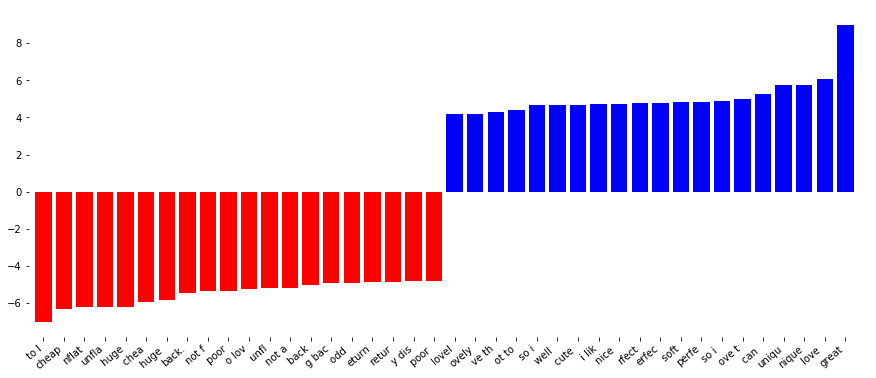

In [313]:
char5_pipe = make_pipeline(CountVectorizer(ngram_range=(5,5),analyzer='char'), Normalizer(),
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
char5_pipe.fit(combined_train, y_train)

lr_char5 = char5_pipe.named_steps['logisticregressioncv']
char5_feature_names = np.array(char5_pipe.named_steps['countvectorizer'].get_feature_names())
char5_scores = char5_pipe.predict(combined_val)

ap_char5 = average_precision_score(y_val, char5_scores)
print("Average precision of logistic regression: {:.3f}".format(ap_char5))

plt.figure(figsize=(15, 6))
plot_important_features(lr_char5.coef_.ravel(), np.array(char5_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

The character ngrams start to perform better as n increases, which makes sense because it will perform better once you start getting n to about the size of words (I set n=5 here as an example). I attribute this improvement to the fact that "great' and "love and "cheap" have now returned as some of the most important features, thus restoring the character ngram to something more akin to a word ngram.

#### Part 3.3: Examing min_df and stop-words

For part 3, I decided to continue using word bigrams because they were the best performing non-unigrams I had tested in this task. First to test out changes to min_df:

Average precision of logistic regression for bigrams: 0.912


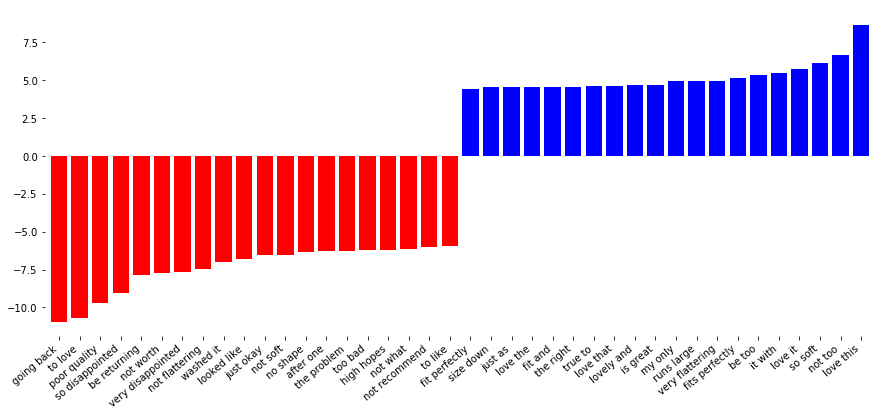

In [314]:
bigram_df_pipe = make_pipeline(CountVectorizer(ngram_range=(2,2), min_df=4), Normalizer(),
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
bigram_df_pipe.fit(combined_train, y_train)

lr_bigram_df = bigram_df_pipe.named_steps['logisticregressioncv']
bigram_df_feature_names = np.array(bigram_df_pipe.named_steps['countvectorizer'].get_feature_names())
bigram_df_scores = bigram_df_pipe.predict(combined_val)

ap_bigram_df = average_precision_score(y_val, bigram_df_scores)
print("Average precision of logistic regression for bigrams: {:.3f}".format(ap_bigram_df))

plt.figure(figsize=(15, 6))
plot_important_features(lr_bigram_df.coef_.ravel(), np.array(bigram_df_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

Changing min_df to 4 seems to have caused a decrease in the average precision of the bigram but perhaps that's because I'm over-restricting the dataset if I limit features to two-word phrases that have to have at least a 4 document frequency. To check this notion, I'm going to test the same parameter settings on a unigram model and evaluate performance.

Average precision of logistic regression for unigrams with min_df=4: 0.923


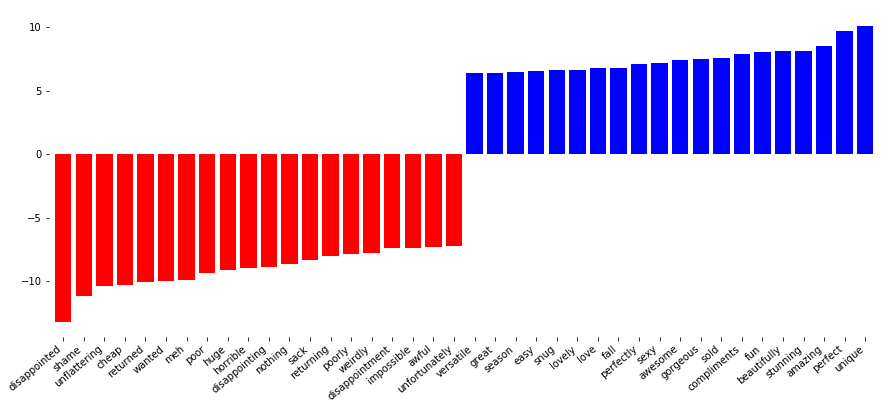

In [315]:
unigram_df_pipe = make_pipeline(CountVectorizer(ngram_range=(1,1), min_df=4), Normalizer(),
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
unigram_df_pipe.fit(combined_train, y_train)

lr_unigram_df = unigram_df_pipe.named_steps['logisticregressioncv']
unigram_df_feature_names = np.array(unigram_df_pipe.named_steps['countvectorizer'].get_feature_names())
unigram_df_scores = unigram_df_pipe.predict(combined_val)

ap_unigram_df = average_precision_score(y_val, unigram_df_scores)
print("Average precision of logistic regression for unigrams with min_df=4: {:.3f}".format(ap_unigram_df))

plt.figure(figsize=(15, 6))
plot_important_features(lr_unigram_df.coef_.ravel(), np.array(unigram_df_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [316]:
print(X_train_combined.shape)
print(X_train_df.shape)
print(unigram_df_pipe.named_steps['countvectorizer'].transform(combined_val).shape)

(11071, 11094)
(11071, 4195)
(3691, 4195)


Oddly, it seems that increasing min_df on the unigrams has caused a slight increase in unigram performance (average precision is now 0.923 while it had previously been 0.922). Additionally, the number of features has dropped significantly, as shown above. Next to examine using stop-words.

Average precision of logistic regression for bigrams: 0.883


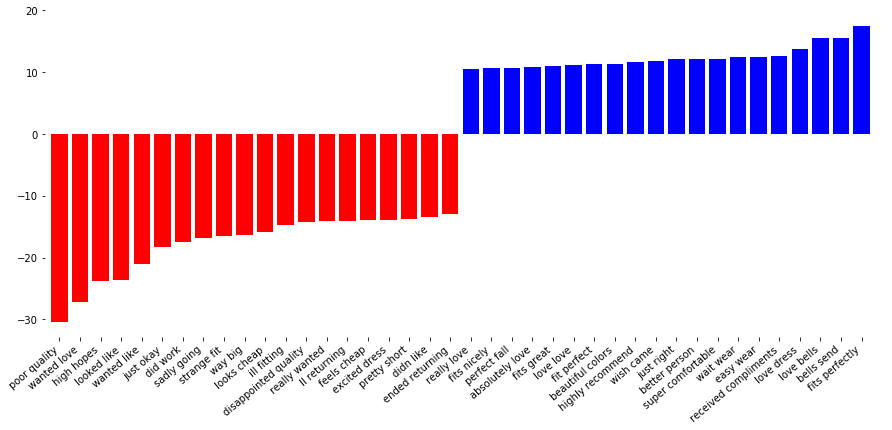

In [317]:
bigram_stop_pipe = make_pipeline(CountVectorizer(ngram_range=(2,2), stop_words='english'), Normalizer(),
                           LogisticRegressionCV(Cs=10,cv=10),memory="cache_folder")
bigram_stop_pipe.fit(combined_train, y_train)

lr_bigram_stop = bigram_stop_pipe.named_steps['logisticregressioncv']
bigram_stop_feature_names = np.array(bigram_stop_pipe.named_steps['countvectorizer'].get_feature_names())
bigram_stop_scores = bigram_stop_pipe.predict(combined_val)

ap_bigram_stop = average_precision_score(y_val, bigram_stop_scores)
print("Average precision of logistic regression for bigrams: {:.3f}".format(ap_bigram_stop))

plt.figure(figsize=(15, 6))
plot_important_features(lr_bigram_stop.coef_.ravel(), np.array(bigram_stop_feature_names), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

It seems that using stop-words did not help model performance again, seeing as average precision dropped to 0.883. From this exploration and the earlier exploration of stop-words usage, it doesn't seem like using stop-words is particularly helpful on this dataset, for reasons I discussed earlier.

The final model I chose from this task is the word unigram, since it outperformed the other n-grams, especially with the parameter min_df set to 4. To evaluated the test set, I used the CountVectorizer(min_df=4) + Normalizer model that was previously used (look one model back) because it had the highest average precision score of all the models considered in this task.

In [318]:
unigram_df_test_scores = unigram_df_pipe.predict(combined_test)

ap_unigram_df_test = average_precision_score(y_test, unigram_df_test_scores)
print("Average precision of logistic regression using test set: {:.3f}".format(ap_unigram_df_test))

Average precision of logistic regression using test set: 0.925


This model performs as well as the final model from Task 2, with an average precision of 0.925.

### Task 4
#### Trying different linear models
I decided to use the Lasso, Ridge, and ElasticNet models in order to adequately compare linear models with the L1 and L2 penalty. For each model I tuned the alpha/l1_ratio parameter and performed cross validation. First, I looked at the Lasso model.

In [330]:
lasso_pipe = make_pipeline(CountVectorizer(ngram_range=(1,1), min_df=4), SelectKBest(k=40),
                           Normalizer(), LassoCV(alphas=np.logspace(-3, 0, 13), cv=10),memory="cache_folder")
lasso_pipe.fit(combined_train, y_train)

lass = lasso_pipe.named_steps['lassocv']
lasso_scores = lasso_pipe.predict(combined_val)

ap_lasso = average_precision_score(y_val, lasso_scores)
print("Average precision of Lasso: {:.3f}".format(ap_lasso))

Average precision of Lasso: 0.971


The Lasso model performed very well, with a average precision score of 0.971.

In [332]:
ridge_pipe = make_pipeline(CountVectorizer(ngram_range=(1,1), min_df=4), SelectKBest(k=40),
                           Normalizer(), RidgeCV(alphas=np.logspace(-3, 0, 13), cv=10),memory="cache_folder")
ridge_pipe.fit(combined_train, y_train)

ridge_scores = ridge_pipe.predict(combined_val)

ap_ridge = average_precision_score(y_val, ridge_scores)
print("Average precision of Ridge: {:.3f}".format(ap_ridge))

Average precision of Ridge: 0.975


The Ridge model outperformed the Lasso model, with an average precision score of 0.975.

In [335]:
net_pipe = make_pipeline(CountVectorizer(ngram_range=(1,1), min_df=4), SelectKBest(k=40),
                           Normalizer(), ElasticNetCV(alphas=np.logspace(-3, 0, 13),
                            l1_ratio = [0.01, .1, .5, .9, .98, 1], cv=10),memory="cache_folder")
net_pipe.fit(combined_train, y_train)

net_scores = net_pipe.predict(combined_val)

ap_net = average_precision_score(y_val, net_scores)
print("Average precision of ElasticNet: {:.3f}".format(ap_net))

Average precision of ElasticNet: 0.975


The ElasticNet model performed in line with the Ridge model, with a score of 0.975. Since both models performed similarly, I decided to use the Ridge model for it's simplicity.

In [339]:
ridge_test_scores = ridge_pipe.predict(combined_test)

ap_ridge_test = average_precision_score(y_test, ridge_test_scores)
print("Average precision of ridge regression using test set: {:.3f}".format(ap_ridge_test))

Average precision of ridge regression using test set: 0.971


The Ridge model performed slightly worse on the test set than it did on the train set, but 0.971 is still a very good average precision score. This score is also higher than the scores for Tasks 1, 2, and 3, which indicates that this is the best model out of all the models evaluated.

There may be a combination of a specific ngram with certain parameters that would outperform my final model but I think my exploration was reasonable. I do have some features that I think are worth trying out. I think it would be worthwhile to examine consecutive letters/words in caps lock, because people who really like/hate the product are more likely to leave emphatic reviews and therefore more likely to use caps lock. This same logic follows for use of punctuation, although it gets a bit trickier with punctuation because for one person, three exclamation points could mean strong emotion, but for another person it could be their default setting. Finally, I think it would be interesting to set a vocabulary of sentiment words like "good", "great", "terrible", and count how many words are not within that vocabulary and explore how that may affect the results, and what new features might be revealed if we remove classic sentiment words.